In [2]:
import plotly.io as pio
pio.renderers.default = 'iframe_connected'

In [1]:
config = {
    "data_dir": "./",
    "epochs": 100,
    "batch_size": 1,
    "learning_rate": 0.1,
    "batches_per_epoch": None,
    "batches_per_epoch_val": None,
    "device":torch.device("cuda")
}
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset,
    config["batch_size"],
    num_workers=4,
    shuffle=True,
    pin_memory=True
)
CHANNEL_NUM = 3

pixel_num = 0
channel_sum = 0
channel_sum_squared = 0
num_batches=0
for data in train_dataloader:
    im = data["image_raw"]
    channel_sum += torch.mean(im,dim=[0,2,3])
    channel_sum_squared += torch.mean(im**2,dim=[0,2,3])
    num_batches +=1

mean = channel_sum/num_batches
std = (channel_sum_squared/num_batches-mean**2)**0.5


NameError: name 'torch' is not defined

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from torch.utils.data import Dataset
import torch.optim as optim
import torch.nn as nn
#preputils
import cv2
from tqdm import tqdm

N_KEYPOINTS = 21
N_IMG_CHANNELS = 3
RAW_IMG_SIZE = 224
MODEL_IMG_SIZE = 256
HEATMAP_SIZE = 64
DATASET_MEANS = [0.3950, 0.4323, 0.2954]
DATASET_STDS = [0.2245, 0.1987, 0.2296]
MODEL_NEURONS = 16

COLORMAP = {
    "thumb": {"ids": [0, 1, 2, 3, 4], "color": "g"},
    "index": {"ids": [0, 5, 6, 7, 8], "color": "c"},
    "middle": {"ids": [0, 9, 10, 11, 12], "color": "b"},
    "ring": {"ids": [0, 13, 14, 15, 16], "color": "m"},
    "little": {"ids": [0, 17, 18, 19, 20], "color": "r"},
}

In [3]:
def projectPoints(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    uv = np.matmul(K, xyz.T).T
    return uv[:,:2] / uv[:,-1:]

In [4]:
def get_norm_parameters(data_dir):
    image_dir = os.path_join(data_dir, "training/rgb")
    image_names = np.sort(os.listdir(image_dir))
    CHANNEL_NUM = 3

    pixel_num = 0
    channel_sum = np.zeros(CHANNEL_NUM)
    channel_sum_squared = np.zeros(CHANNEL_NUM)

    for image in image_names:
        im = cv2.imread(image) #cv2 reads image in BGR format. Shape is WxHxCHANNEL_NUM
        im = im/255.0
        pixel_num += (im.size/CHANNEL_NUM)
        channel_sum += np.sum(im, axis=(0,1))
        channel_sum_squared = np.sum(np.square(im), axis=(0,1))
    
    bgr_mean = channel_sum / pixel_num
    bgr_std = np.sqrt(channel_sum_squared / pixel_num - np.square(bgr_mean))

    rgb_mean = list(bgr_mean)[::-1]
    rgb_std = list(bgr_std)[::-1]

    return rgb_mean, rgb_std

In [5]:
def get_norm_parameters(data_dir):
    image_dir = os.path_join(data_dir, "training/rgb")
    transform = transforms.Compose([
        transforms.Resize(128),
        transforms.ToTensor()
    ])
    dataset = datasets.ImageFolder(image_dir, transforms)
    dataloader = torch.utils.data.Dataloader(dataset, batch_size=32)

    return rgb_mean, rgb_std

In [6]:
def show_data(dataset, n_samples=12):
    n_cols = 4
    n_rows = int(np.ceil(n_samples/n_cols))
    plt.figure(figsize=[15, n_rows*4])
  
    ids=np.random.choice(dataset.__len__(), n_samples, replace=False)
    for i, id_ in enumerate(ids, 1):
        sample = dataset.__getitem__(id_)


        keypoints = sample["keypoints"].numpy()
        keypoints = keypoints * MODEL_IMG_SIZE
        image = sample["image"].numpy()
        #image = TF.resize(image,).numpy()
        image = np.moveaxis(image, 0, -1)
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)
        plt.scatter(keypoints[:, 0], keypoints[:, 1], c="k", alpha=0.5)
        for finger, params in COLORMAP.items():
            plt.plot(
                keypoints[params["ids"], 0],
                keypoints[params["ids"], 1],
                params["color"]
            )
        
    plt.tight_layout()
    plt.show()

In [1]:
from FreiHAND import FreiHAND 
from StackedHourGlass import StackedHourGlass 
from Trainer import Trainer
import torchvision as TF
model = StackedHourGlass(num_stacks=8,num_residual=1)


In [10]:
torch.cuda.empty_cache()

In [6]:
model = StackedHourGlass(num_stacks=8,num_residual=1)
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

25453352

In [13]:
model = model.to("cuda")
inputs = torch.randn((6,3,256,256)).to("cuda")
outputs = model(inputs)
loss_fn = torch.nn.MSELoss()
parameters = model.parameters()
optimizer = optim.RMSprop(model.parameters(), lr=0.00025, alpha=0.99,eps=1e-8)

In [18]:
labels = [torch.randn(outputs[0].shape).to("cuda") for i in range(len(outputs))]

In [19]:
loss = 0
for i in range(len(outputs)):
    loss += loss_fn(outputs[i], labels[i])
print(loss)

tensor(9.3504, device='cuda:0', grad_fn=<AddBackward0>)


In [8]:

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class Bottleneck(nn.Module):
    def __init__(self, channels, in_channels=-1):
        super(Bottleneck, self).__init__()
        self.BNmomentum = 0.9
        self.channels = channels
        if (in_channels == -1):
            self.in_channels = channels
            self.skipLayer = nn.Identity()
        else:
            self.in_channels = in_channels
            self.skipLayer = nn.Conv2d(in_channels,channels,1,1)
        self.mainConv = nn.Sequential(
            nn.BatchNorm2d(self.in_channels, self.BNmomentum),
            nn.ReLU(inplace = True),
            nn.Conv2d(self.in_channels, channels//2, 1, 1, 0),
            nn.BatchNorm2d(channels//2, self.BNmomentum),
            nn.ReLU(inplace = True),
            nn.Conv2d(channels//2, channels//2, 3, 1, 1),
            nn.BatchNorm2d(channels//2, self.BNmomentum),
            nn.ReLU(inplace = True),
            nn.Conv2d(channels//2, channels, 1, 1, 0)
        )
        self.relu = nn.ReLU(inplace = True)
    def forward(self, X):
        conv = self.mainConv(X)
        X = self.skipLayer(X)
        return torch.add(conv, X)
        
class LinearLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(LinearLayer, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels,1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )
    def forward(self, X):
        return self.conv(X)

class HourGlass(nn.Module):
    def __init__(self, order, channels, num_residual):
        super(HourGlass, self).__init__()
        self.order = order
        self.channels = channels
        self.num_residual = num_residual
        self.upper_bottleneck = nn.Sequential(*[Bottleneck(channels) for i in range(self.num_residual)])
        self.max_pool = nn.MaxPool2d(2,2)
        self.lower_bottleneck = nn.Sequential(*[Bottleneck(channels) for i in range(self.num_residual)])
        self.output_bottleneck = nn.Sequential(*[Bottleneck(channels) for i in range(self.num_residual)])
        if order > 1:
            self.hg = HourGlass(order-1, channels, num_residual)
        else:
            self.deep_residuals = nn.Sequential(*[Bottleneck(channels) for i in range(self.num_residual)])
        self.upsample = nn.Upsample(scale_factor=2)

    def forward(self, X):
        #Upper branch
        up1 = X
        up1 = self.upper_bottleneck(up1)
        
        #Lower branch
        low1 = self.max_pool(X)
        low1 = self.lower_bottleneck(low1)
        
        low2 = low1
        if self.order > 1:
            #Go into deeper level of hourglass
            low2 = self.hg(low2)
        else:
            #Achieved deepest level, perform residuals at the latent space
            low2 = self.deep_residuals(low2)
        
        low3 = low2
        low3 = self.output_bottleneck(low3)
        up2 = self.upsample(low3)
        if up2.shape != up1.shape:  
            up2 = TF.resize(up2, size=up1.shape[2:])
        return torch.add(up2,up1)

    def to(self, device):
        new_self = super(HourGlass,self).to(device)
        new_self.upper_bottleneck = self.upper_bottleneck.to(device)
        new_self.max_pool = self.max_pool.to(device)
        new_self.lower_bottleneck = self.lower_bottleneck.to(device)
        self.output_bottleneck = self.output_bottleneck.to(device)
        if self.order > 1:
            new_self.hg = self.hg.to(device)
        else:
            new_self.deep_residuals = self.deep_residuals.to(device)
        new_self.upsample = self.upsample.to(device)
        return new_self

class BeginStackedHourGlass(torch.nn.Module):
    def __init__(self, in_channels,out_channels):
        super(BeginStackedHourGlass, self).__init__()
        self.begin = nn.Sequential(
            nn.Conv2d(in_channels,64,7,2,3),
            nn.BatchNorm2d(momentum=0.9,num_features=64),
            nn.ReLU(inplace=True),
            Bottleneck(128, in_channels=64),
            nn.MaxPool2d(2,2),
            Bottleneck(128),
            Bottleneck(out_channels, in_channels = 128)
        )
    def forward(self, X):
        return self.begin(X)

class StackedHourGlass(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=21, num_stacks = 1, num_residual=1, hourglass_depth=4,n_features=256):
        super(StackedHourGlass, self).__init__()
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.relu = nn.ReLU(inplace=True)
        self.num_stacks = num_stacks
        self.num_residual = num_residual
        self.begin = BeginStackedHourGlass(in_channels,n_features)
        self.hourglasses = nn.ModuleList([HourGlass(hourglass_depth,n_features,self.num_residual) for i in range(self.num_stacks)])
        self.intermediate_bottlenecks = nn.ModuleList([nn.Sequential(*[Bottleneck(n_features) for j in range(self.num_residual)]) for i in range(self.num_stacks)])
        self.linear_layers = nn.ModuleList([LinearLayer(n_features,n_features) for i in range(self.num_stacks)])
        self.Ys = nn.ModuleList([nn.Conv2d(n_features,self.out_channels,1) for i in range(self.num_stacks)])
        self.intermediate1s = nn.ModuleList([nn.Conv2d(n_features,n_features,1) for i in range(self.num_stacks-1)])
        self.intermediate2s = nn.ModuleList([nn.Conv2d(self.out_channels,n_features,1) for i in range(self.num_stacks-1)])
    def forward(self, X):
        X = self.begin(X)
        ys = []
        for i in range(self.num_stacks):
            X = self.hourglasses[i](X)

            X = self.intermediate_bottlenecks[i](X)
            X = self.linear_layers[i](X)

            Y = self.Ys[i](X)
            ys.append(Y)
            if i < self.num_stacks -1:
                y_intermediate_1 = self.intermediate1s[i](X)
                y_intermediate_2 = self.intermediate2s[i](Y)
                X = torch.add(y_intermediate_1,y_intermediate_2)
        return ys

In [66]:
from torchsummary import summary
model = StackedHourGlass(num_stacks=4).to("cuda")
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

12867284

In [54]:
state_dict = torch.load("/data/nnuser/saoudio/hand_pose_detection/model_04012022141354_140.pt")
# create new OrderedDict that does not contain `module.`
# load params
model = StackedHourGlass(num_stacks=8,num_residual=1)
model.load_state_dict(state_dict)

<All keys matched successfully>

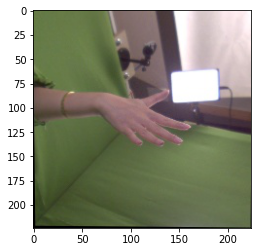

In [11]:
config = {
    "data_dir": "./",
    "epochs": 100,
    "batch_size": 6,
    "learning_rate": 0.0025,
    "batches_per_epoch": 1,
    "batches_per_epoch_val": 1,
    "device": torch.device("cuda")
}
model = model.to("cuda")
train_dataset = FreiHAND(config=config, set_type="train")
item = train_dataset.__getitem__(1)
image_raw = item["image_raw"].numpy()
image = item["image"]
#image = TF.resize(image,).numpy()
image_raw = np.moveaxis(image_raw, 0, -1)
plt.imshow(image_raw)

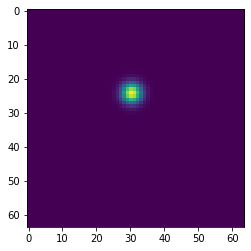

In [13]:
plt.imshow(train_dataset.__getitem__(0)["heatmaps"][2].numpy())

In [14]:
heatmaps = model(torch.unsqueeze(image,0).to("cuda"))

In [15]:
model2 = StackedHourGlass(num_stacks=8,num_residual=1).to("cuda")

In [16]:
heatmaps2 = model2(torch.unsqueeze(image,0).to("cuda"))

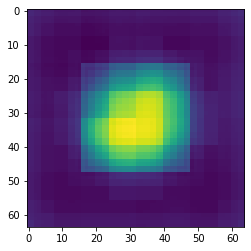

In [17]:
plt.imshow(heatmaps[-1][0][-1].cpu().detach().numpy())

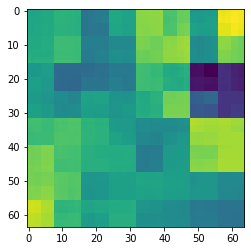

In [18]:
plt.imshow(heatmaps2[-1][0][0].cpu().detach().numpy())

In [10]:
from FreiHAND import FreiHAND 
from StackedHourGlass import StackedHourGlass 
from Trainer import Trainer
import torchvision as TF
device = torch.device("cuda")

config = {
    "data_dir": "./",
    "epochs": 100,
    "batch_size": 10,
    "learning_rate": 0.0025,
    "batches_per_epoch": 1,
    "batches_per_epoch_val": 1,
    "device": device
}

#Initialize training dataset
train_dataset = FreiHAND(config=config, set_type="train")
train_dataloader = DataLoader(
    train_dataset,
    config["batch_size"],
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

#Initialize validation dataset
val_dataset = FreiHAND(config=config, set_type="val")
val_dataloader = DataLoader(
    val_dataset,
    config["batch_size"],
    num_workers=4,
    shuffle=True,
    pin_memory=True
)

#Initialize loss, optimizer, and scheduler
loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(model.parameters(), lr=config["learning_rate"])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, factor = 0.2, patience=10, verbose=True
) 
trainer = Trainer(model, optimizer, loss_fn, device, lambda x: (x["image"], x["heatmaps"]), epochs = config["epochs"], early_stop=False,epoch_load_bar=True,checkpoint_frequency=10000)
trainer.train(train_dataloader, val_dataloader)

Rank: 0, Epoch: 1/100, Train Loss=0.0257010758, Val Loss=1.2279633491244194e+20, LR=0.0025


Rank: 0, Epoch: 2/100, Train Loss=6.926428318, Val Loss=2.6353323166894878e+31, LR=0.0025


Rank: 0, Epoch: 3/100, Train Loss=9.9015951157, Val Loss=2.9392226218238884e+28, LR=0.0025


Rank: 0, Epoch: 4/100, Train Loss=1.1656563282, Val Loss=7.437615054315723e+26, LR=0.0025


Rank: 0, Epoch: 5/100, Train Loss=0.9535938501, Val Loss=8.446857786223853e+22, LR=0.0025


Rank: 0, Epoch: 6/100, Train Loss=0.48255831, Val Loss=1.29447661729638e+18, LR=0.0025


Rank: 0, Epoch: 7/100, Train Loss=0.2795668542, Val Loss=188651237539840.0, LR=0.0025


Rank: 0, Epoch: 8/100, Train Loss=0.1487710178, Val Loss=714119774208.0, LR=0.0025


Rank: 0, Epoch: 9/100, Train Loss=0.0806876943, Val Loss=3289924864.0, LR=0.0025


Rank: 0, Epoch: 10/100, Train Loss=0.0549104735, Val Loss=85504600.0, LR=0.0025


Rank: 0, Epoch: 11/100, Train Loss=0.0385364257, Val Loss=2227692.5, LR=0.0025


Rank: 0, Epoch: 12/100, Train Loss=0.0342120752, Val Loss=182356.953125, LR=0.0025


Rank: 0, Epoch: 13/100, Train Loss=0.0326076634, Val Loss=13678.7626953125, LR=0.0025


Rank: 0, Epoch: 14/100, Train Loss=0.027856715, Val Loss=2010.7933349609, LR=0.0025


Rank: 0, Epoch: 15/100, Train Loss=0.0263134055, Val Loss=323.2055053711, LR=0.0025


Rank: 0, Epoch: 16/100, Train Loss=0.0256289355, Val Loss=77.7684783936, LR=0.0025


Rank: 0, Epoch: 17/100, Train Loss=0.0252475366, Val Loss=19.3886489868, LR=0.0025


Rank: 0, Epoch: 18/100, Train Loss=0.0250044521, Val Loss=6.5670938492, LR=0.0025


Rank: 0, Epoch: 19/100, Train Loss=0.0248293113, Val Loss=2.1871137619, LR=0.0025


Rank: 0, Epoch: 20/100, Train Loss=0.0250398256, Val Loss=0.912312448, LR=0.0025


Rank: 0, Epoch: 21/100, Train Loss=0.0251731072, Val Loss=0.6044101715, LR=0.0025


Rank: 0, Epoch: 22/100, Train Loss=0.0245937873, Val Loss=0.2222532779, LR=0.0025


Rank: 0, Epoch: 23/100, Train Loss=0.0244558938, Val Loss=0.10499423, LR=0.0025


Rank: 0, Epoch: 24/100, Train Loss=0.024362335, Val Loss=0.0554794557, LR=0.0025


Rank: 0, Epoch: 25/100, Train Loss=0.024288699, Val Loss=0.0386356525, LR=0.0025


Rank: 0, Epoch: 26/100, Train Loss=0.0242217295, Val Loss=0.0304564722, LR=0.0025


Rank: 0, Epoch: 27/100, Train Loss=0.0241662916, Val Loss=0.0275333896, LR=0.0025


Rank: 0, Epoch: 28/100, Train Loss=0.0241305679, Val Loss=0.0259315893, LR=0.0025


Rank: 0, Epoch: 29/100, Train Loss=0.0240728445, Val Loss=0.0253283717, LR=0.0025


Rank: 0, Epoch: 30/100, Train Loss=0.0249750149, Val Loss=0.0250218641, LR=0.0025


Rank: 0, Epoch: 31/100, Train Loss=0.0260961298, Val Loss=0.0248445719, LR=0.0025


Rank: 0, Epoch: 32/100, Train Loss=0.0249280222, Val Loss=0.0246848837, LR=0.0025


Rank: 0, Epoch: 33/100, Train Loss=0.02439964, Val Loss=0.0245575812, LR=0.0025


Rank: 0, Epoch: 34/100, Train Loss=0.0241438374, Val Loss=0.0244886614, LR=0.0025


Rank: 0, Epoch: 35/100, Train Loss=0.0240063798, Val Loss=0.0244329423, LR=0.0025


Rank: 0, Epoch: 36/100, Train Loss=0.0239251368, Val Loss=0.0245456323, LR=0.0025


Rank: 0, Epoch: 37/100, Train Loss=0.0238749292, Val Loss=0.0244008321, LR=0.0025


Rank: 0, Epoch: 38/100, Train Loss=0.023840677, Val Loss=0.0243715439, LR=0.0025


Rank: 0, Epoch: 39/100, Train Loss=0.0238139257, Val Loss=0.0243229084, LR=0.0025


Rank: 0, Epoch: 40/100, Train Loss=0.0238047726, Val Loss=0.0243078806, LR=0.0025


Rank: 0, Epoch: 41/100, Train Loss=0.0238095634, Val Loss=0.0242957529, LR=0.0025


Rank: 0, Epoch: 42/100, Train Loss=0.0238823388, Val Loss=0.0242474712, LR=0.0025


Rank: 0, Epoch: 43/100, Train Loss=0.0239073299, Val Loss=0.0243587922, LR=0.0025


Rank: 0, Epoch: 44/100, Train Loss=0.0238885693, Val Loss=0.024455769, LR=0.0025


Rank: 0, Epoch: 45/100, Train Loss=0.0239635631, Val Loss=0.0242570098, LR=0.0025


Rank: 0, Epoch: 46/100, Train Loss=0.0241872203, Val Loss=0.0248411242, LR=0.0025


Rank: 0, Epoch: 47/100, Train Loss=0.0241873395, Val Loss=0.02454626, LR=0.0025


Rank: 0, Epoch: 48/100, Train Loss=0.0243332516, Val Loss=0.0252883527, LR=0.0025


Rank: 0, Epoch: 49/100, Train Loss=0.0245466344, Val Loss=0.0248964652, LR=0.0025


Rank: 0, Epoch: 50/100, Train Loss=0.0248736404, Val Loss=0.0265970957, LR=0.0025


Rank: 0, Epoch: 51/100, Train Loss=0.0253083743, Val Loss=0.0250379872, LR=0.0025


Rank: 0, Epoch: 52/100, Train Loss=0.0258653853, Val Loss=0.0500285327, LR=0.0025


Rank: 0, Epoch: 53/100, Train Loss=0.0262013972, Val Loss=0.0287676193, LR=0.0025


Rank: 0, Epoch: 54/100, Train Loss=0.0264793765, Val Loss=0.033565823, LR=0.0025


Rank: 0, Epoch: 55/100, Train Loss=0.0266121924, Val Loss=0.0274995007, LR=0.0025


Rank: 0, Epoch: 56/100, Train Loss=0.0266755633, Val Loss=0.0303891506, LR=0.0025


Rank: 0, Epoch: 57/100, Train Loss=0.0265973918, Val Loss=0.0269216504, LR=0.0025


Rank: 0, Epoch: 58/100, Train Loss=0.0266873427, Val Loss=0.0301873665, LR=0.0025


Rank: 0, Epoch: 59/100, Train Loss=0.0262399893, Val Loss=0.0267530791, LR=0.0025


Rank: 0, Epoch: 60/100, Train Loss=0.0257092491, Val Loss=0.0281464923, LR=0.0025


Rank: 0, Epoch: 61/100, Train Loss=0.0251274984, Val Loss=0.0253598634, LR=0.0025


Rank: 0, Epoch: 62/100, Train Loss=0.0247453768, Val Loss=0.0266987849, LR=0.0025


Rank: 0, Epoch: 63/100, Train Loss=0.024532143, Val Loss=0.0253457334, LR=0.0025


Rank: 0, Epoch: 64/100, Train Loss=0.0245789327, Val Loss=0.0251539163, LR=0.0025


Rank: 0, Epoch: 65/100, Train Loss=0.0245086662, Val Loss=0.4328583479, LR=0.0025


Rank: 0, Epoch: 66/100, Train Loss=0.0249127597, Val Loss=0.0246997364, LR=0.0025


Rank: 0, Epoch: 67/100, Train Loss=0.0258566979, Val Loss=0.0417256244, LR=0.0025


Rank: 0, Epoch: 68/100, Train Loss=0.025573412, Val Loss=0.0454158448, LR=0.0025


Rank: 0, Epoch: 69/100, Train Loss=0.0255879592, Val Loss=0.0422543548, LR=0.0025


Rank: 0, Epoch: 70/100, Train Loss=0.0256820582, Val Loss=0.0371368751, LR=0.0025


Rank: 0, Epoch: 71/100, Train Loss=0.0258809775, Val Loss=0.041625455, LR=0.0025


Rank: 0, Epoch: 72/100, Train Loss=0.0263661873, Val Loss=0.0400287807, LR=0.0025


Rank: 0, Epoch: 73/100, Train Loss=0.027760677, Val Loss=0.0699893013, LR=0.0025


Rank: 0, Epoch: 74/100, Train Loss=0.0292200278, Val Loss=0.0486209542, LR=0.0025


Rank: 0, Epoch: 75/100, Train Loss=0.0306412578, Val Loss=0.1434617043, LR=0.0025


Rank: 0, Epoch: 76/100, Train Loss=0.032482855, Val Loss=0.0977180004, LR=0.0025


Rank: 0, Epoch: 77/100, Train Loss=0.0341683291, Val Loss=0.1691979468, LR=0.0025


Rank: 0, Epoch: 78/100, Train Loss=0.0354446881, Val Loss=0.1238690391, LR=0.0025


Rank: 0, Epoch: 79/100, Train Loss=0.0375769772, Val Loss=0.3219181597, LR=0.0025


Rank: 0, Epoch: 80/100, Train Loss=0.0389873646, Val Loss=0.119902581, LR=0.0025


Rank: 0, Epoch: 81/100, Train Loss=0.0389678888, Val Loss=2.2496063709, LR=0.0025


Rank: 0, Epoch: 82/100, Train Loss=0.045191355, Val Loss=0.2660716772, LR=0.0025


Rank: 0, Epoch: 83/100, Train Loss=0.0479683504, Val Loss=2.434094429, LR=0.0025


Rank: 0, Epoch: 84/100, Train Loss=0.0448819585, Val Loss=0.4156571627, LR=0.0025


Rank: 0, Epoch: 85/100, Train Loss=0.0436720699, Val Loss=1.1834439039, LR=0.0025


Rank: 0, Epoch: 86/100, Train Loss=0.0435781777, Val Loss=0.1109273285, LR=0.0025


Rank: 0, Epoch: 87/100, Train Loss=0.0442910343, Val Loss=2.105951786, LR=0.0025


Rank: 0, Epoch: 88/100, Train Loss=0.0444954261, Val Loss=1.0658786297, LR=0.0025


Rank: 0, Epoch: 89/100, Train Loss=0.0442397445, Val Loss=0.4759064019, LR=0.0025


Rank: 0, Epoch: 90/100, Train Loss=0.0439704992, Val Loss=0.3168637753, LR=0.0025


Rank: 0, Epoch: 91/100, Train Loss=0.0439491235, Val Loss=0.2997559309, LR=0.0025


Rank: 0, Epoch: 92/100, Train Loss=0.0446162485, Val Loss=0.1408509761, LR=0.0025


Rank: 0, Epoch: 93/100, Train Loss=0.0482899807, Val Loss=0.5460144877, LR=0.0025


Rank: 0, Epoch: 94/100, Train Loss=0.0542255901, Val Loss=0.0962792933, LR=0.0025


Rank: 0, Epoch: 95/100, Train Loss=0.0550809801, Val Loss=0.3893091679, LR=0.0025


Rank: 0, Epoch: 96/100, Train Loss=0.0592376478, Val Loss=0.3100401163, LR=0.0025


Rank: 0, Epoch: 97/100, Train Loss=0.0576453805, Val Loss=0.9344854355, LR=0.0025


Rank: 0, Epoch: 98/100, Train Loss=0.0547610819, Val Loss=0.1059865355, LR=0.0025


Rank: 0, Epoch: 99/100, Train Loss=0.0509563759, Val Loss=4.2329216003, LR=0.0025


Rank: 0, Epoch: 100/100, Train Loss=0.0464323312, Val Loss=0.1941533387, LR=0.0025


In [ ]:
def show_batch_predictions(batch_data, model):
    inputs = batch_data["image"]
    true_keypoints = batch_data["keypoints"].numpy()
    batch_size = true_keypoints.shape[0]
    pred_heatmaps = model(inputs)
    pred_heatmaps = pred_heatmaps.detach().numpy()
    pred_keypoints = heatmaps_to_coordinates(pred_heatmaps)
    images = batch_data["image_raw"].numpy()
    images = np.moveaxis(images, 1, -1)

    plt.figure(figsize=[12, 4 *batch_size])
    for i in range(batch_size):
        image = images[i]
        true_keypoints_img = true_keypoints[i] * RAW_IMG_SIZE
        pred_keypoints_img = pred_keypoints[i] * RAW_IMG_SIZE

        plt.subplot(batch_size, 3, i * 3 + 1)
        plt.imshow(image)
        plt.title("Image")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 2)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                true_keypoints_img[params["ids"], 0],
                true_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("True Keypoints")
        plt.axis("off")

        plt.subplot(batch_size, 3, i * 3 + 3)
        plt.imshow(image)
        for finger, params in COLORMAP.items():
            plt.plot(
                pred_keypoints_img[params["ids"], 0],
                pred_keypoints_img[params["ids"], 1],
                params["color"],
            )
        plt.title("Pred Keypoints")
        plt.axis("off")
    plt.tight_layout()
def heatmaps_to_coordinates(heatmaps):
    """
    Heatmaps is a numpy array
    Its size - (batch_size, n_keypoints, img_size, img_size)
    """
    batch_size = heatmaps.shape[0]
    sums = heatmaps.sum(axis=-1).sum(axis=-1)
    sums = np.expand_dims(sums, [2, 3])
    normalized = heatmaps / sums
    x_prob = normalized.sum(axis=2)
    y_prob = normalized.sum(axis=3)

    arr = np.tile(np.float32(np.arange(0, 128)), [batch_size, 21, 1])
    x = (arr * x_prob).sum(axis=2)
    y = (arr * y_prob).sum(axis=2)
    keypoints = np.stack([x, y], axis=-1)
    return keypoints / 128

In [ ]:
import torch.distributed as dist
import torch.multiprocessing as mp
# parallel_model = nn.parallel.DistributedDataParallel(StackedHourGlass(num_stacks=5,num_residual=4), device_ids = [0,1,2,3])
# input = torch.rand(1,3,128,128)
# output = parallel_model(input)
def train_model(rank, world_size):
    #Configure process, model, and hyperparameters
    dist.init_process_group("gloo", rank=rank, world_size=world_size)
    model = StackedHourGlass(num_stacks=5,num_residual=4).to(rank)
    ddp_model = nn.parallel.DistributedDataParallel(model, device_ids=[rank])
    device = torch.device("cuda:{}".format(rank))
    config = {
        "data_dir": "./",
        "epochs": 100,
        "batch_size": 4,
        "learning_rate": 0.1,
        "batches_per_epoch": None,
        "batches_per_epoch_val": None,
        "device": device
    }

    #Initialize training dataset
    train_dataset = FreiHAND(config=config, set_type="train")
    sampler = DistributedSampler(
        train_dataset,
        num_replicas=world_size,
        rank=rank,
        shuffle=True
    )
    train_dataloader = DataLoader(
        train_dataset,
        config["batch_size"],
        num_workers=4,
        sampler=sampler,
        pin_memory=True
    )

    #Initialize validation dataset
    val_dataset = FreiHAND(config=config, set_type="val")
    sampler = DistributedSampler(
        val_dataset,
        num_replicas=world_size,
        rank=rank,
        shuffle=True
    )
    val_dataloader = DataLoader(
        val_dataset,
        config["batch_size"],
        num_workers=4,
        sampler=sampler,
        pin_memory=True
    )

    #Initialize optimizer and scheduler
    optimizer = optim.SGD(ddp_model.parameters(), lr=0.0025 )
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer=optimizer, factor = 0.2, patience=10, verbose=True
    )
    trainer = Trainer(ddp_model, optimizer, loss_fn, device, lambda x: (x["image"], x["heatmaps"]), epochs = config["epochs"])
    trainer.train(train_dataloader, val_dataloader)
    dist.destroy_process_group()

def init_process(rank, size, fn, backend="gloo"):
    dist.init_process_group(backend, rank=rank, world_size=size)
    fn(rank,size)
if __name__ == "__main__":
    world_size = torch.cuda.device_count()
    processes = []
    try: 
        mp.set_start_method("spawn")
    except:
        pass
    for rank in range(world_size):
        p = mp.Process(target=init_process, args=(rank, world_size, train_model))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/data/nnuser/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/data/nnuser/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'init_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/data/nnuser/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/data/nnuser/anaconda3/lib/python3.8/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'init_process' on <module '__main__' (built-in)>
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/data/nnuser/anaconda3/lib/python3.8/multiprocessi